## Import

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import matplotlib.pyplot as plt

from dataset.preprocess import Preprocess
from dataset.distribution import *
from global_.trainer import GlobalTrainer
from global_.evaluator import GlobalEvaluator
from client.trainer import ClientTrainer
from client.evaluator import ClientEvaluator
from models.models import model
from configs.conf_loader import *

/home/sanskriti/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Prepare Dataset

In [2]:
pre = Preprocess()
pre.client_preprocess_train()
pre.client_preprocess_test()
pre.global_preprocess_test()

## Global Model

In [3]:
global_model = model
print(global_model)

CNN_MNIST(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


## Train

In [4]:
global_trainer = GlobalTrainer(global_model, pre.client_train_sets, fed_learn_method=aggregator_method)
global_trainer.train()

global_training_epoch:   0%|          | 0/10 [00:00<?, ?it/s]

global_training_epoch: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


In [5]:
# fig = plt.figure(figsize=(24, 10))
# for i in range(num_clients):
#     fig.add_subplot(2, int(num_clients/2), (i+1))
#     X = global_trainer.client_trainer_set[i].loss_history
#     Y = [i+1 for i in range(len(X))]
#     plt.plot(Y, X)
#     plt.title(f'client: {i}')
#     plt.xlabel('epochs')
#     plt.ylabel('loss')

## Test

In [6]:
client_evaluator_set = [ClientEvaluator(i, global_model, pre.client_test_sets[i]) for i in range(num_clients)]
global_evaluator = GlobalEvaluator(global_model, pre.global_test)

In [7]:
avg_client_acc = 0
avg_client_loss = 0
avg_client_conf_mat = torch.zeros([10, 10])  
  
for i in range(num_clients):
    client_evaluator_set[i].test()
    avg_client_acc += client_evaluator_set[i].accuracy
    avg_client_loss += client_evaluator_set[i].loss
    print(type(client_evaluator_set[i].conf_mat), type(avg_client_conf_mat))
    avg_client_conf_mat = torch.add(avg_client_conf_mat, client_evaluator_set[i].conf_mat)
    
avg_client_acc /= num_clients
avg_client_loss /= num_clients
avg_client_conf_mat  = torch.div(avg_client_conf_mat, num_clients)
    

client [0]: 100%|██████████| 32/32 [00:00<00:00, 140.07it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [1]: 100%|██████████| 32/32 [00:00<00:00, 162.07it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [2]: 100%|██████████| 32/32 [00:00<00:00, 171.15it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [3]: 100%|██████████| 32/32 [00:00<00:00, 141.74it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [4]: 100%|██████████| 32/32 [00:00<00:00, 173.09it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [5]: 100%|██████████| 32/32 [00:00<00:00, 162.76it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [6]: 100%|██████████| 32/32 [00:00<00:00, 171.41it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [7]: 100%|██████████| 32/32 [00:00<00:00, 171.61it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [8]: 100%|██████████| 32/32 [00:00<00:00, 170.38it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [9]: 100%|██████████| 32/32 [00:00<00:00, 170.83it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [8]:
# fig = plt.figure(figsize=(24, 10))
# for i in range(num_clients):
#     fig.add_subplot(2, int(num_clients/2), (i+1))
#     plt.imshow(client_evaluator_set[i].conf_mat, cmap='Blues')
#     plt.title(f'client: {i}')

In [9]:
global_evaluator.test()

global_evaluation: 100%|██████████| 313/313 [00:02<00:00, 156.02it/s]


Text(0.5, 1.0, 'client average')

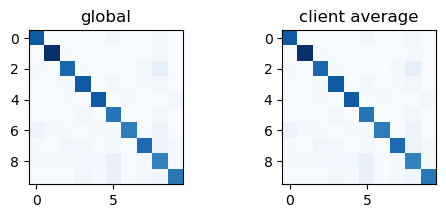

In [10]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.imshow(global_evaluator.conf_mat, cmap='Blues')
plt.title('global')
fig.add_subplot(1, 2, 2)
plt.imshow(avg_client_conf_mat, cmap='Blues')
plt.title('client average')

In [11]:
print('Global Accuracy', global_evaluator.accuracy, '\tClient avg Accuracy', avg_client_acc)
print('Global Loss' , global_evaluator.loss, '\tClient avg Loss', avg_client_loss)

Global Accuracy 0.8800918530351438 	Client avg Accuracy 0.87958984375
Global Loss 1.2132492378574022 	Client avg Loss 1.2106172403176667
